In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import numpy
import matplotlib.pyplot as plt
from statistics import mean
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
root_dir="/content/drive/MyDrive/FINAL YEAR PROJECT (AMRITA)/FINAL YEAR PROJECT (PHASE 1 )/DATA"

In [ ]:
res1=[]
res2=[]
res3=[]
res4=[]
for i in os.listdir(root_dir):
  path = os.path.join(root_dir,i)
  ps=sorted(os.listdir(path))
  for j in range(5):
    p=ps[j]
    a=os.path.join(path,p)
    c=sorted(list(os.listdir(a)))
    b=os.path.join(a,c[0])
    d=os.path.join(a,c[1])
    e=os.path.join(a,c[2])
    f=os.path.join(a,c[3])
    res1.append(b)
    res2.append(d)
    res3.append(e)
    res4.append(f)

In [ ]:
def remove_missing(x, y, time, missing):
	mx = np.array(x==missing, dtype=int)
	my = np.array(y==missing, dtype=int)
	x = x[(mx+my) != 2]
	y = y[(mx+my) != 2]
	time = time[(mx+my) != 2]
	return x, y, time

In [ ]:
def blink_detection(x, y, time, missing=0.0, minlen=10):
	
	"""Detects blinks, defined as a period of missing data that lasts for at
	least a minimal amount of samples
	
	arguments
	x		-	numpy array of x positions
	y		-	numpy array of y positions
	time		-	numpy array of EyeTribe timestamps
	keyword arguments
	missing	-	value to be used for missing data (default = 0.0)
	minlen	-	integer indicating the minimal amount of consecutive
				missing samples
	
	returns
	Sblk, Eblk
				Sblk	-	list of lists, each containing [starttime]
				Eblk	-	list of lists, each containing [starttime, endtime, duration]
	"""
	
	# empty list to contain data
	Sblk = []
	Eblk = []
	
	# check where the missing samples are
	mx = numpy.array(x==missing, dtype=int)
	my = numpy.array(y==missing, dtype=int)
	miss = numpy.array((mx+my) == 2, dtype=int)
	
	# check where the starts and ends are (+1 to counteract shift to left)
	diff = numpy.diff(miss)
	starts = numpy.where(diff==1)[0] + 1
	ends = numpy.where(diff==-1)[0] + 1
	
	# compile blink starts and ends
	for i in range(len(starts)):
		# get starting index
		s = starts[i]
		# get ending index
		if i < len(ends):
			e = ends[i]
		elif len(ends) > 0:
			e = ends[-1]
		else:
			e = -1
		# append only if the duration in samples is equal to or greater than
		# the minimal duration
		if e-s >= minlen:
			# add starting time
			Sblk.append([time[s]])
			# add ending time
			Eblk.append([time[s],time[e],time[e]-time[s]])
	
	return Sblk, Eblk

def remove_missing(x, y, time, missing):
	mx = numpy.array(x==missing, dtype=int)
	my = numpy.array(y==missing, dtype=int)
	x = x[(mx+my) != 2]
	y = y[(mx+my) != 2]
	time = time[(mx+my) != 2]
	return x, y, time

In [ ]:
def fixation_detection(x, y, time, missing=0.0, maxdist=25, mindur=50):
	
	"""Detects fixations, defined as consecutive samples with an inter-sample
	distance of less than a set amount of pixels (disregarding missing data)
	
	arguments
	x		-	numpy array of x positions
	y		-	numpy array of y positions
	time		-	numpy array of EyeTribe timestamps
	keyword arguments
	missing	-	value to be used for missing data (default = 0.0)
	maxdist	-	maximal inter sample distance in pixels (default = 25)
	mindur	-	minimal duration of a fixation in milliseconds; detected
				fixation cadidates will be disregarded if they are below
				this duration (default = 100)
	
	returns
	Sfix, Efix
				Sfix	-	list of lists, each containing [starttime]
				Efix	-	list of lists, each containing [starttime, endtime, duration, endx, endy]
	"""

	x, y, time = remove_missing(x, y, time, missing)

	# empty list to contain data
	Sfix = []
	Efix = []
	
	# loop through all coordinates
	si = 0
	fixstart = False
	for i in range(1,len(x)):
		# calculate Euclidean distance from the current fixation coordinate
		# to the next coordinate
		squared_distance = ((x[si]-x[i])**2 + (y[si]-y[i])**2)
		dist = 0.0
		if squared_distance > 0:
			dist = squared_distance**0.5
		# check if the next coordinate is below maximal distance
		if dist <= maxdist and not fixstart:
			# start a new fixation
			si = 0 + i
			fixstart = True
			Sfix.append([time[i]])
		elif dist > maxdist and fixstart:
			# end the current fixation
			fixstart = False
			# only store the fixation if the duration is ok
			if time[i-1]-Sfix[-1][0] >= mindur:
				Efix.append([Sfix[-1][0], time[i-1], time[i-1]-Sfix[-1][0], x[si], y[si]])
			# delete the last fixation start if it was too short
			else:
				Sfix.pop(-1)
			si = 0 + i
		elif not fixstart:
			si += 1
	#add last fixation end (we can lose it if dist > maxdist is false for the last point)
	if len(Sfix) > len(Efix):
		Efix.append([Sfix[-1][0], time[len(x)-1], time[len(x)-1]-Sfix[-1][0], x[si], y[si]])
	return Sfix, Efix

In [ ]:
def saccade_detection(x, y, time, missing=0.0, minlen=5, maxvel=40, maxacc=340):
	
	"""Detects saccades, defined as consecutive samples with an inter-sample
	velocity of over a velocity threshold or an acceleration threshold
	
	arguments
	x		-	numpy array of x positions
	y		-	numpy array of y positions
	time		-	numpy array of tracker timestamps in milliseconds
	keyword arguments
	missing	-	value to be used for missing data (default = 0.0)
	minlen	-	minimal length of saccades in milliseconds; all detected
				saccades with len(sac) < minlen will be ignored
				(default = 5)
	maxvel	-	velocity threshold in pixels/second (default = 40)
	maxacc	-	acceleration threshold in pixels / second**2
				(default = 340)
	
	returns
	Ssac, Esac
			Ssac	-	list of lists, each containing [starttime]
			Esac	-	list of lists, each containing [starttime, endtime, duration, startx, starty, endx, endy]
	"""
	x, y, time = remove_missing(x, y, time, missing)

	# CONTAINERS
	Ssac = []
	Esac = []

	# INTER-SAMPLE MEASURES
	# the distance between samples is the square root of the sum
	# of the squared horizontal and vertical interdistances
	intdist = (numpy.diff(x)**2 + numpy.diff(y)**2)**0.5
	# get inter-sample times
	inttime = numpy.diff(time)
	# recalculate inter-sample times to seconds
	inttime = inttime / 1000.0
	
	# VELOCITY AND ACCELERATION
	# the velocity between samples is the inter-sample distance
	# divided by the inter-sample time
	vel = intdist / inttime
	# the acceleration is the sample-to-sample difference in
	# eye movement velocity
	acc = numpy.diff(vel)

	# SACCADE START AND END
	t0i = 0
	stop = False
	while not stop:
		# saccade start (t1) is when the velocity or acceleration
		# surpass threshold, saccade end (t2) is when both return
		# under threshold
	
		# detect saccade starts
		sacstarts = numpy.where((vel[1+t0i:] > maxvel).astype(int) + (acc[t0i:] > maxacc).astype(int) >= 1)[0]
		if len(sacstarts) > 0:
			# timestamp for starting position
			t1i = t0i + sacstarts[0] + 1
			if t1i >= len(time)-1:
				t1i = len(time)-2
			t1 = time[t1i]
			
			# add to saccade starts
			Ssac.append([t1])
			
			# detect saccade endings
			sacends = numpy.where((vel[1+t1i:] < maxvel).astype(int) + (acc[t1i:] < maxacc).astype(int) == 2)[0]
			if len(sacends) > 0:
				# timestamp for ending position
				t2i = sacends[0] + 1 + t1i + 2
				if t2i >= len(time):
					t2i = len(time)-1
				t2 = time[t2i]
				dur = t2 - t1

				# ignore saccades that did not last long enough
				if dur >= minlen:
					# add to saccade ends
					Esac.append([t1, t2, dur, x[t1i], y[t1i], x[t2i], y[t2i]])
				else:
					# remove last saccade start on too low duration
					Ssac.pop(-1)

				# update t0i
				t0i = 0 + t2i
			else:
				stop = True
		else:
			stop = True
	
	return Ssac, Esac

In [ ]:
average_left_saccade_duration = []
average_right_saccade_duration = []
average_right_pupil_diameter = []
average_left_pupil_diameter = []
left_saccade_duration = []
right_saccade_duration = []
right_fixation_duration = []
left_fixation_duration = []
average_right_fixation_duration = []
average_left_fixation_duration = []
fixation_time = []
fixation_count = []
saccade_count = []

for i in range(len(res1)):
  df = pd.read_csv(res1[i])
  df1 = df.loc[:,["Time","Left Pupil Pos X","Left Pupil Pos Y","Right Pupil Pos X","Right Pupil Pos Y","Right Pupil Diameter (mm)","Left Pupil Diameter (mm)"]]
  data1,data2 = saccade_detection(np.array(df1["Left Pupil Pos X"]),np.array(df1["Left Pupil Pos Y"]) ,np.array(df1["Time"]))
  data3,data4 = saccade_detection(np.array(df["Right Pupil Pos X"]),np.array(df1["Right Pupil Pos Y"]) , np.array(df1["Time"]))
  data5,data6 = fixation_detection(np.array(df1["Left Pupil Pos X"]),np.array(df1["Left Pupil Pos Y"]) ,np.array(df1["Time"]))
  data7,data8 = fixation_detection(np.array(df1["Right Pupil Pos X"]),np.array(df1["Right Pupil Pos Y"]) , np.array(df1["Time"]))
  for i in range(len(data2)):
    left_saccade_duration.append(data2[i][2])
  for i in range(len(data4)):
    right_saccade_duration.append(data4[i][2])
  for i in range(len(data6)):
    left_fixation_duration.append(data6[i][2])
  for i in range(len(data8)):
    right_fixation_duration.append(data8[i][2])
  fixation_time.append((df1.iloc[-1,0] - df1.iloc[0,0])/1000)
  saccade_count.append(len(data2))
  fixation_count.append(len(data6))
  average_left_saccade_duration.append(mean(left_saccade_duration))
  average_right_saccade_duration.append(mean(right_saccade_duration))
  average_left_fixation_duration.append(mean(left_fixation_duration))
  average_right_fixation_duration.append(mean(right_fixation_duration))
  average_right_pupil_diameter.append(mean(df1.iloc[:,5]))
  average_left_pupil_diameter.append(mean(df1.iloc[:,6]))
TMT_A1 = pd.DataFrame(list(zip(average_left_saccade_duration, average_right_saccade_duration,average_right_pupil_diameter,average_left_pupil_diameter,average_left_fixation_duration,average_right_fixation_duration,fixation_time,saccade_count,fixation_count)),columns =["average_left_saccade_duration","average_right_saccade_duration","average_right_pupil_diameter","average_left_pupil_diameter","average_left_fixation_duration","average_right_fixation_duration","fixation_time","saccade_count","fixation_count"])

In [ ]:
average_left_saccade_duration = []
average_right_saccade_duration = []
average_right_pupil_diameter = []
average_left_pupil_diameter = []
left_saccade_duration = []
right_saccade_duration = []
right_fixation_duration = []
left_fixation_duration = []
average_right_fixation_duration = []
average_left_fixation_duration = []
for i in range(len(res2)):
  df = pd.read_csv(res2[i])
  df1 = df.loc[:,["Time","Left Pupil Pos X","Left Pupil Pos Y","Right Pupil Pos X","Right Pupil Pos Y","Right Pupil Diameter (mm)","Left Pupil Diameter (mm)"]]
  data1,data2 = saccade_detection(np.array(df1["Left Pupil Pos X"]),np.array(df1["Left Pupil Pos Y"]) ,np.array(df1["Time"]))
  data3,data4 = saccade_detection(np.array(df["Right Pupil Pos X"]),np.array(df1["Right Pupil Pos Y"]) , np.array(df1["Time"]))
  data5,data6 = fixation_detection(np.array(df1["Left Pupil Pos X"]),np.array(df1["Left Pupil Pos Y"]) ,np.array(df1["Time"]))
  data7,data8 = fixation_detection(np.array(df1["Right Pupil Pos X"]),np.array(df1["Right Pupil Pos Y"]) , np.array(df1["Time"]))
  for i in range(len(data2)):
    left_saccade_duration.append(data2[i][2])
  for i in range(len(data4)):
    right_saccade_duration.append(data4[i][2])
  for i in range(len(data6)):
    left_fixation_duration.append(data6[i][2])
  for i in range(len(data8)):
    right_fixation_duration.append(data8[i][2])
  fixation_time.append((df1.iloc[-1,0] - df1.iloc[0,0])/1000)
  saccade_count.append(len(data2))
  fixation_count.append(len(data6))
  average_left_saccade_duration.append(mean(left_saccade_duration))
  average_right_saccade_duration.append(mean(right_saccade_duration))
  average_left_fixation_duration.append(mean(left_fixation_duration))
  average_right_fixation_duration.append(mean(right_fixation_duration))
  average_right_pupil_diameter.append(mean(df1.iloc[:,5]))
  average_left_pupil_diameter.append(mean(df1.iloc[:,6]))
TMT_A2 = pd.DataFrame(list(zip(average_left_saccade_duration, average_right_saccade_duration,average_right_pupil_diameter,average_left_pupil_diameter,average_left_fixation_duration,average_right_fixation_duration,fixation_time,saccade_count,fixation_count)),columns =["average_left_saccade_duration","average_right_saccade_duration","average_right_pupil_diameter","average_left_pupil_diameter","average_left_fixation_duration","average_right_fixation_duration","fixation_time","saccade_count","fixation_count"])

In [ ]:
average_left_saccade_duration = []
average_right_saccade_duration = []
average_right_pupil_diameter = []
average_left_pupil_diameter = []
left_saccade_duration = []
right_saccade_duration = []
right_fixation_duration = []
left_fixation_duration = []
average_right_fixation_duration = []
average_left_fixation_duration = []
for i in range(len(res3)):
  df = pd.read_csv(res3[i])
  df1 = df.loc[:,["Time","Left Pupil Pos X","Left Pupil Pos Y","Right Pupil Pos X","Right Pupil Pos Y","Right Pupil Diameter (mm)","Left Pupil Diameter (mm)"]]
  data1,data2 = saccade_detection(np.array(df1["Left Pupil Pos X"]),np.array(df1["Left Pupil Pos Y"]) ,np.array(df1["Time"]))
  data3,data4 = saccade_detection(np.array(df["Right Pupil Pos X"]),np.array(df1["Right Pupil Pos Y"]) , np.array(df1["Time"]))
  data5,data6 = fixation_detection(np.array(df1["Left Pupil Pos X"]),np.array(df1["Left Pupil Pos Y"]) ,np.array(df1["Time"]))
  data7,data8 = fixation_detection(np.array(df1["Right Pupil Pos X"]),np.array(df1["Right Pupil Pos Y"]) , np.array(df1["Time"]))
  for i in range(len(data2)):
    left_saccade_duration.append(data2[i][2])
  for i in range(len(data4)):
    right_saccade_duration.append(data4[i][2])
  for i in range(len(data6)):
    left_fixation_duration.append(data6[i][2])
  for i in range(len(data8)):
    right_fixation_duration.append(data8[i][2])
  fixation_time.append((df1.iloc[-1,0] - df1.iloc[0,0])/1000)
  saccade_count.append(len(data2))
  fixation_count.append(len(data6))
  average_left_saccade_duration.append(mean(left_saccade_duration))
  average_right_saccade_duration.append(mean(right_saccade_duration))
  average_left_fixation_duration.append(mean(left_fixation_duration))
  average_right_fixation_duration.append(mean(right_fixation_duration))
  average_right_pupil_diameter.append(mean(df1.iloc[:,5]))
  average_left_pupil_diameter.append(mean(df1.iloc[:,6]))
TMT_B1 = pd.DataFrame(list(zip(average_left_saccade_duration, average_right_saccade_duration,average_right_pupil_diameter,average_left_pupil_diameter,average_left_fixation_duration,average_right_fixation_duration,fixation_time,saccade_count,fixation_count)),columns =["average_left_saccade_duration","average_right_saccade_duration","average_right_pupil_diameter","average_left_pupil_diameter","average_left_fixation_duration","average_right_fixation_duration","fixation_time","saccade_count","fixation_count"])

In [ ]:
average_left_saccade_duration = []
average_right_saccade_duration = []
average_right_pupil_diameter = []
average_left_pupil_diameter = []
left_saccade_duration = []
right_saccade_duration = []
right_fixation_duration = []
left_fixation_duration = []
average_right_fixation_duration = []
average_left_fixation_duration = []
for i in range(len(res4)):
  df = pd.read_csv(res4[i])
  df1 = df.loc[:,["Time","Left Pupil Pos X","Left Pupil Pos Y","Right Pupil Pos X","Right Pupil Pos Y","Right Pupil Diameter (mm)","Left Pupil Diameter (mm)"]]
  data1,data2 = saccade_detection(np.array(df1["Left Pupil Pos X"]),np.array(df1["Left Pupil Pos Y"]) ,np.array(df1["Time"]))
  data3,data4 = saccade_detection(np.array(df["Right Pupil Pos X"]),np.array(df1["Right Pupil Pos Y"]) , np.array(df1["Time"]))
  data5,data6 = fixation_detection(np.array(df1["Left Pupil Pos X"]),np.array(df1["Left Pupil Pos Y"]) ,np.array(df1["Time"]))
  data7,data8 = fixation_detection(np.array(df1["Right Pupil Pos X"]),np.array(df1["Right Pupil Pos Y"]) , np.array(df1["Time"]))
  for i in range(len(data2)):
    left_saccade_duration.append(data2[i][2])
  for i in range(len(data4)):
    right_saccade_duration.append(data4[i][2])
  for i in range(len(data6)):
    left_fixation_duration.append(data6[i][2])
  for i in range(len(data8)):
    right_fixation_duration.append(data8[i][2])
  fixation_time.append((df1.iloc[-1,0] - df1.iloc[0,0])/1000)
  saccade_count.append(len(data2))
  fixation_count.append(len(data6))
  average_left_saccade_duration.append(mean(left_saccade_duration))
  average_right_saccade_duration.append(mean(right_saccade_duration))
  average_left_fixation_duration.append(mean(left_fixation_duration))
  average_right_fixation_duration.append(mean(right_fixation_duration))
  average_right_pupil_diameter.append(mean(df1.iloc[:,5]))
  average_left_pupil_diameter.append(mean(df1.iloc[:,6]))
TMT_B2 = pd.DataFrame(list(zip(average_left_saccade_duration, average_right_saccade_duration,average_right_pupil_diameter,average_left_pupil_diameter,average_left_fixation_duration,average_right_fixation_duration,fixation_time,saccade_count,fixation_count)),columns =["average_left_saccade_duration","average_right_saccade_duration","average_right_pupil_diameter","average_left_pupil_diameter","average_left_fixation_duration","average_right_fixation_duration","fixation_time","saccade_count","fixation_count"])

In [ ]:
TMT_B1

,average_left_saccade_duration,average_right_saccade_duration,average_right_pupil_diameter,average_left_pupil_diameter,average_left_fixation_duration,average_right_fixation_duration,fixation_time,saccade_count,fixation_count
0,176.493805,162.358080,3.778439,3.236877,420.035000,492.922789,11.910695,56,9
1,116.624194,118.871292,3.438249,3.143385,747.884083,822.350087,14.206332,77,6
2,142.079664,129.655522,2.623866,2.124735,610.922150,658.332100,14.605573,78,4
3,125.116814,138.816621,1.295784,3.251682,680.040800,777.780978,7.934918,47,9
4,143.797216,157.689979,3.782989,4.043645,569.519375,625.924746,7.119801,49,5
...,...,...,...,...,...,...,...,...,...
95,161.285330,174.507489,2.985624,2.842061,475.098011,468.751917,7.003355,46,8
96,160.893016,173.925169,4.385395,3.991562,477.632892,470.410035,7.086531,42,4
97,160.767386,173.570563,3.885512,3.987260,477.642118,470.107752,14.505763,60,21
98,162.950210,175.583914,4.702425,4.127244,473.756907,466.647140,11.278563,60,14


In [ ]:
# file_name1 = 'TMT_B2.xlsx'
# TMT_B2.to_excel(file_name1)

In [ ]:
dir="/content/drive/MyDrive/FINAL YEAR PROJECT (AMRITA)/FINAL YEAR PROJECT (PHASE 1 )/PROCESSED DATA"

In [ ]:
TMT = []
for i in os.listdir(dir):
  data = os.path.join(dir,i)
  TMT.append(data)
TMT[0],TMT[3] = TMT[3],TMT[0]

In [ ]:
A1 = TMT[0]
A2 = TMT[1]
B1 = TMT[2]
B2 = TMT[3]

In [ ]:
TMT_A1 = pd.read_excel(A1)
TMT_A2 = pd.read_excel(A2)
TMT_B1 = pd.read_excel(B1)
TMT_B2 = pd.read_excel(B2)

In [ ]:
TMT_A1

,average_left_saccade_duration,average_right_saccade_duration,average_right_pupil_diameter,average_left_pupil_diameter,average_left_fixation_duration,average_right_fixation_duration,fixation_time,saccade_count,fixation_count,mmse_score
0,89.909436,90.445667,3.934730,3.747885,990.810877,1192.357371,11.910695,56,9,15
1,84.767970,84.460572,3.653446,3.381750,1265.679489,1452.059398,14.206332,77,6,10
2,99.810297,100.907866,3.070520,2.801204,979.400288,1036.885266,14.605573,78,4,25
3,95.915500,102.777700,2.925494,3.553485,1162.177896,1318.041593,7.934918,47,9,16
4,111.448221,118.460298,5.623660,5.342084,825.589479,906.255666,7.119801,49,5,14
...,...,...,...,...,...,...,...,...,...,...
95,141.729673,151.640176,3.395775,4.014303,593.444699,608.374086,7.003355,46,8,17
96,141.202948,150.843832,4.504165,4.010049,596.031680,610.974150,7.086531,42,4,16
97,140.937674,150.428473,4.024595,4.114097,596.784588,611.237272,14.505763,60,21,13
98,141.740060,151.135922,5.340216,4.844009,591.548066,605.778957,11.278563,60,14,19


In [ ]:
TMT_A1["label"] = "None" *len(TMT_A1["mmse_score"])
for i in range(len(TMT_A1["mmse_score"])):
  if TMT_A1["mmse_score"][i]  <= 20:
    TMT_A1["label"][i] = "low"
  elif 20 < TMT_A1["mmse_score"][i] <= 25:
    TMT_A1["label"][i] = "medium"
  else:
    TMT_A1["label"][i] = "high"

In [ ]:
TMT_A2["label"] = "None" *len(TMT_A2["mmse_score"])
for i in range(len(TMT_A2["mmse_score"])):
  if TMT_A2["mmse_score"][i]  <= 20:
    TMT_A2["label"][i] = "low"
  elif 20 < TMT_A2["mmse_score"][i] <= 25:
    TMT_A2["label"][i] = "medium"
  else:
    TMT_A2["label"][i] = "high"

In [ ]:
TMT_B1["label"] = "None" *len(TMT_B1["mmse_score"])
for i in range(len(TMT_B1["mmse_score"])):
  if TMT_B1["mmse_score"][i]  <= 20:
    TMT_B1["label"][i] = "low"
  elif 20 < TMT_B1["mmse_score"][i] <= 25:
    TMT_B1["label"][i] = "medium"
  else:
    TMT_B1["label"][i] = "high"

In [ ]:
TMT_B2["label"] = "None" *len(TMT_B2["mmse_score"])
for i in range(len(TMT_B2["mmse_score"])):
  if TMT_B2["mmse_score"][i]  <= 20:
    TMT_B2["label"][i] = "low"
  elif 20 < TMT_B2["mmse_score"][i] <= 25:
    TMT_B2["label"][i] = "medium"
  else:
    TMT_B2["label"][i] = "high"

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
X = TMT_A1[["average_left_saccade_duration","average_right_fixation_duration","average_right_pupil_diameter","fixation_time","saccade_count","fixation_count"]]
y = TMT_A1[["label"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

In [ ]:
X1 = TMT_A2[["average_left_saccade_duration","average_right_fixation_duration","average_right_pupil_diameter","fixation_time","saccade_count","fixation_count"]]
y1 = TMT_A2[["label"]]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.35, random_state=42)

In [ ]:
X2 = TMT_B1[["average_left_saccade_duration","average_right_fixation_duration","average_right_pupil_diameter","fixation_time","saccade_count","fixation_count"]]
y2 = TMT_B1[["label"]]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.35, random_state=42)

In [ ]:
X3 = TMT_B2[["average_left_saccade_duration","average_right_fixation_duration","average_right_pupil_diameter","fixation_time","saccade_count","fixation_count"]]
y3 = TMT_B2[["label"]]
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.35, random_state=42)

Accuracy of TMT_A1 : 0.34285714285714286
 
 
Accuracy of TMT_A2 : 0.37142857142857144
 
 
Accuracy of TMT_B1 : 0.5142857142857142
 
 
Accuracy of TMT_B2 : 0.4
 
 
Confusion Matrix
 


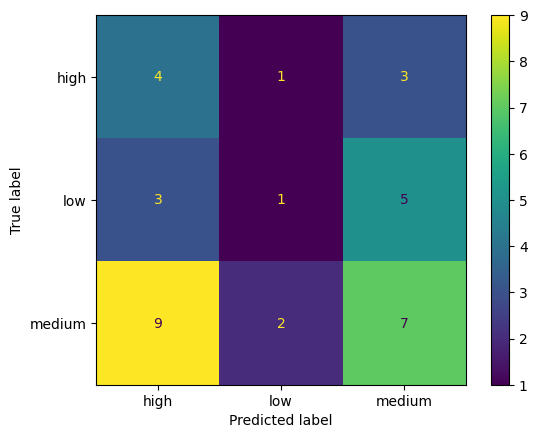

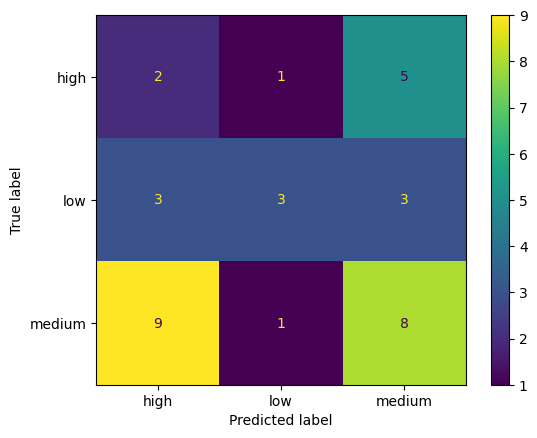

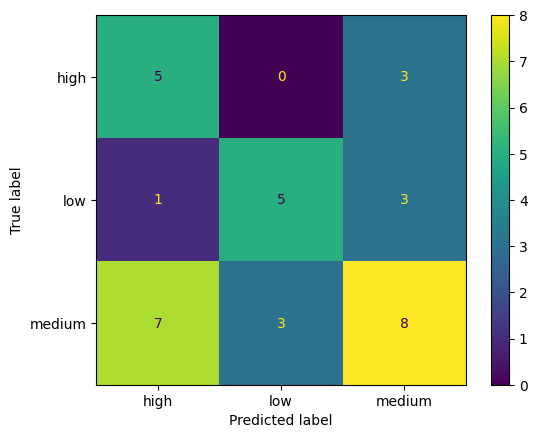

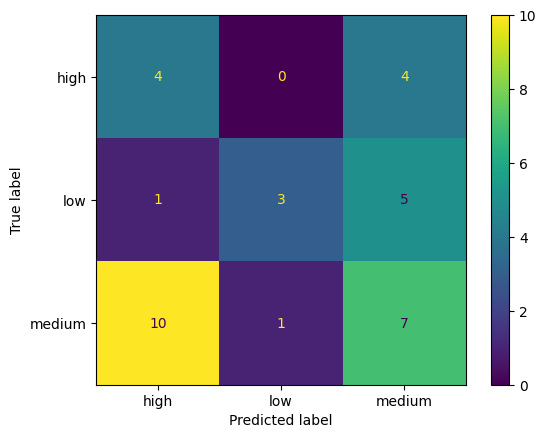

In [ ]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=svclassifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svclassifier.classes_)
print(f"Accuracy of TMT_A1 : {accuracy_score(y_test, y_pred)}")
print(" ")
disp.plot()
print(" ")

svclassifier = SVC(kernel='linear')
svclassifier.fit(X1_train, y1_train)
y_pred = svclassifier.predict(X1_test)
cm = confusion_matrix(y_test, y_pred, labels=svclassifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svclassifier.classes_)
print(f"Accuracy of TMT_A2 : {accuracy_score(y_test, y_pred)}")
print(" ")
disp.plot()
print(" ")

svclassifier = SVC(kernel='linear')
svclassifier.fit(X2_train, y2_train)
y_pred = svclassifier.predict(X2_test)
cm = confusion_matrix(y_test, y_pred, labels=svclassifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svclassifier.classes_)
print(f"Accuracy of TMT_B1 : {accuracy_score(y_test, y_pred)}")
print(" ")
disp.plot()
print(" ")

svclassifier = SVC(kernel='linear')
svclassifier.fit(X3_train, y3_train)
y_pred = svclassifier.predict(X3_test)
cm = confusion_matrix(y_test, y_pred, labels=svclassifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=svclassifier.classes_)
print(f"Accuracy of TMT_B2 : {accuracy_score(y_test, y_pred)}")
print(" ")
disp.plot()
print(" ")

print("Confusion Matrix")
print(" ")


Accuracy of TMT_A1 : 0.34285714285714286
 
Confusion Matrix
 
Accuracy of TMT_A2 : 0.37142857142857144
 
 
Accuracy of TMT_B1 : 0.37142857142857144
 
 
Accuracy of TMT_B2 : 0.42857142857142855
 
 
Confusion Matrix
 


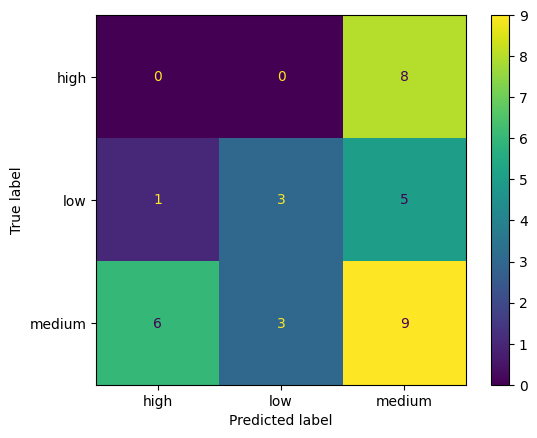

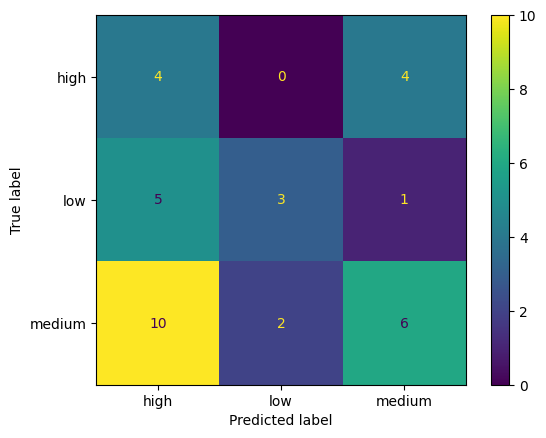

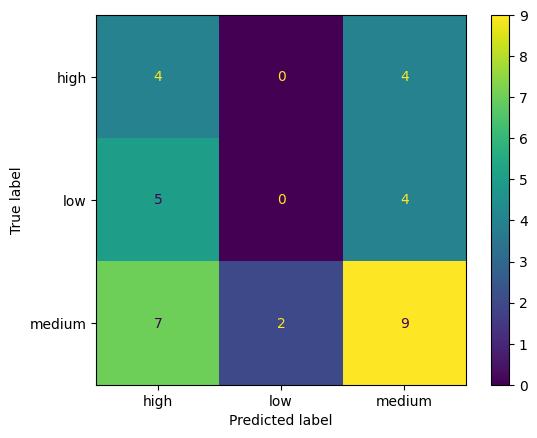

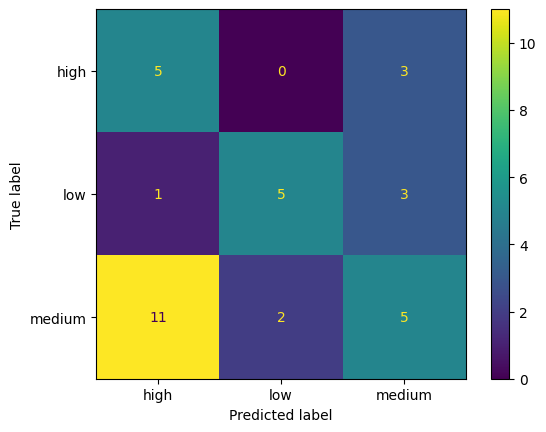

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=neigh.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=neigh.classes_)
print(f"Accuracy of TMT_A1 : {accuracy_score(y_test, y_pred)}")
print(" ")
disp.plot()
print("Confusion Matrix")
print(" ")


neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(X1_train, y1_train)
y_pred = neigh.predict(X1_test)
cm = confusion_matrix(y_test, y_pred, labels=neigh.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=neigh.classes_)
print(f"Accuracy of TMT_A2 : {accuracy_score(y_test, y_pred)}")
print(" ")
disp.plot()
print(" ")

neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(X2_train, y2_train)
y_pred = neigh.predict(X2_test)
cm = confusion_matrix(y_test, y_pred, labels=neigh.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=neigh.classes_)
print(f"Accuracy of TMT_B1 : {accuracy_score(y_test, y_pred)}")
print(" ")
disp.plot()
print(" ")

neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(X3_train, y3_train)
y_pred = neigh.predict(X3_test)
cm = confusion_matrix(y_test, y_pred, labels=neigh.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=neigh.classes_)
print(f"Accuracy of TMT_B2 : {accuracy_score(y_test, y_pred)}")
print(" ")
disp.plot()
print(" ")

print("Confusion Matrix")
print(" ")


Accuracy of TMT_A1 : 0.5714285714285714
 
 
Accuracy of TMT_A2 : 0.8
 
 
Accuracy of TMT_B1 : 0.6857142857142857
 
 
Accuracy of TMT_B2 : 0.7428571428571429
 
 
Confusion Matrix
 


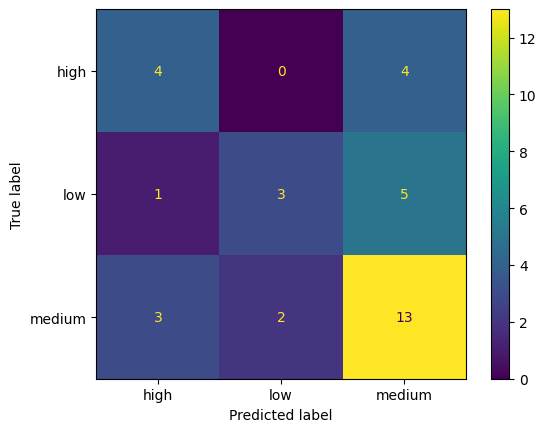

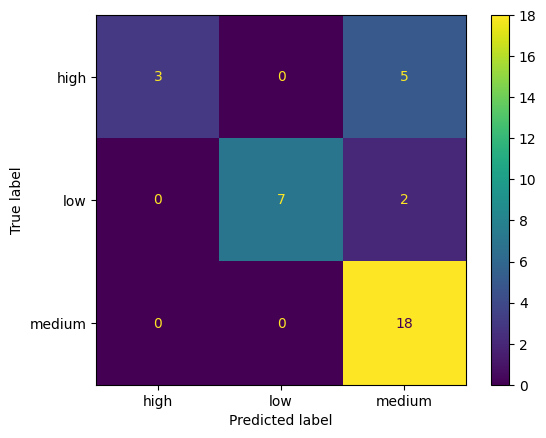

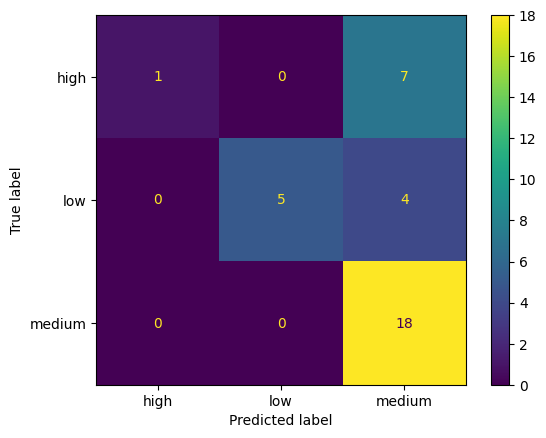

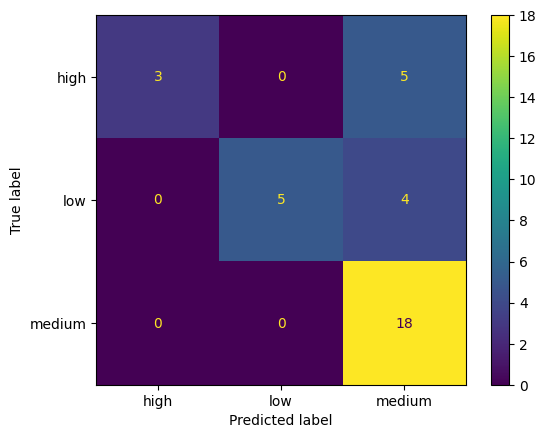

In [ ]:
rfm = RandomForestClassifier(max_depth=2, random_state=0)
rfm.fit(X_train, y_train)
y_pred = rfm.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=rfm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfm.classes_)
print(f"Accuracy of TMT_A1 : {accuracy_score(y_test, y_pred)}")
print(" ")
disp.plot()
print(" ")

rfm = RandomForestClassifier(max_depth=2, random_state=0)
rfm.fit(X1, y1)
y_pred = rfm.predict(X1_test)
cm = confusion_matrix(y_test, y_pred, labels=rfm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfm.classes_)
print(f"Accuracy of TMT_A2 : {accuracy_score(y_test, y_pred)}")
print(" ")
disp.plot()
print(" ")

rfm = RandomForestClassifier(max_depth=2, random_state=0)
rfm.fit(X2, y2)
y_pred = rfm.predict(X2_test)
cm = confusion_matrix(y_test, y_pred, labels=rfm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfm.classes_)
print(f"Accuracy of TMT_B1 : {accuracy_score(y_test, y_pred)}")
print(" ")
disp.plot()
print(" ")

rfm = RandomForestClassifier(max_depth=2, random_state=0)
rfm.fit(X3, y3)
y_pred = rfm.predict(X3_test)
cm = confusion_matrix(y_test, y_pred, labels=rfm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfm.classes_)
print(f"Accuracy of TMT_B2 : {accuracy_score(y_test, y_pred)}")
print(" ")
disp.plot()
print(" ")

print("Confusion Matrix")
print(" ")


Accuracy : 0.7428571428571429
 
 
Accuracy of TMT_A2 : 0.8
 
 
Accuracy of TMT_B1 : 0.8
 
 
Accuracy of TMT_B2 : 0.8
 
 
Confusion Matrix
 


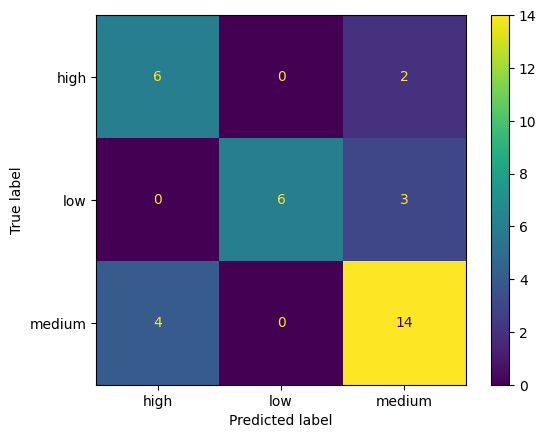

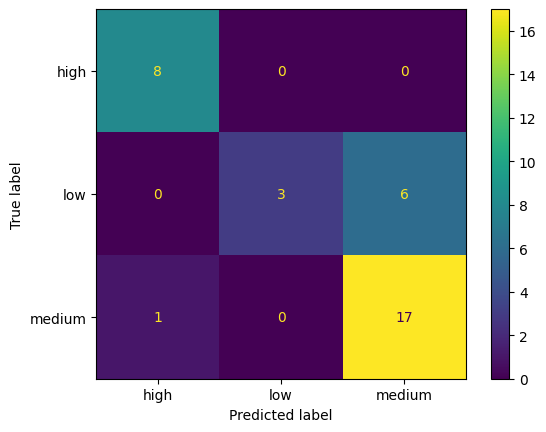

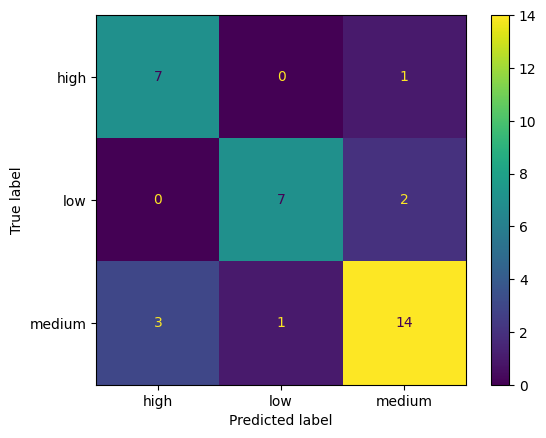

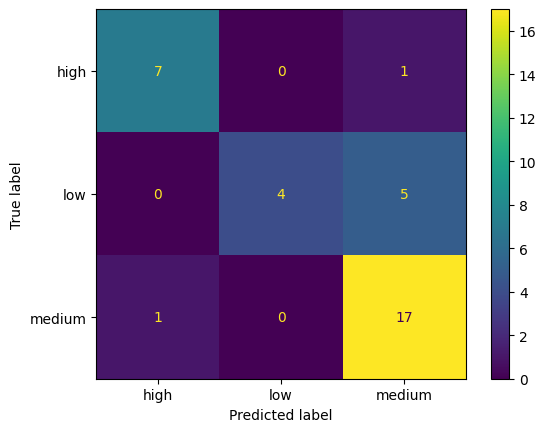

In [ ]:
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(X, y)
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
print(f"Accuracy : {accuracy_score(y_test, y_pred)}")
print(" ")
disp.plot()
print(" ")

clf = AdaBoostClassifier(n_estimators=100)
clf.fit(X1, y1)
y_pred = clf.predict(X1_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
print(f"Accuracy of TMT_A2 : {accuracy_score(y_test, y_pred)}")
print(" ")
disp.plot()
print(" ")

clf = AdaBoostClassifier(n_estimators=100)
clf.fit(X2, y2)
y_pred = clf.predict(X2_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
print(f"Accuracy of TMT_B1 : {accuracy_score(y_test, y_pred)}")
print(" ")
disp.plot()
print(" ")

clf = AdaBoostClassifier(n_estimators=100)
clf.fit(X3, y3)
y_pred = clf.predict(X3_test)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
print(f"Accuracy of TMT_B2 : {accuracy_score(y_test, y_pred)}")
print(" ")
disp.plot()
print(" ")

print("Confusion Matrix")
print(" ")

In [ ]:
a1 = "/content/drive/MyDrive/FINAL YEAR PROJECT (AMRITA)/FINAL YEAR PROJECT (PHASE 1 )/A1.PNG"
a2 = "/content/drive/MyDrive/FINAL YEAR PROJECT (AMRITA)/FINAL YEAR PROJECT (PHASE 1 )/A2.PNG"
b1 = "/content/drive/MyDrive/FINAL YEAR PROJECT (AMRITA)/FINAL YEAR PROJECT (PHASE 1 )/B1.PNG"
b2 = "/content/drive/MyDrive/FINAL YEAR PROJECT (AMRITA)/FINAL YEAR PROJECT (PHASE 1 )/B2.PNG"

In [ ]:
for i in os.listdir(root_dir):
  path = os.path.join(root_dir,i)

In [ ]:
sample = "/content/drive/MyDrive/FINAL YEAR PROJECT (AMRITA)/FINAL YEAR PROJECT (PHASE 1 )/DATA/vinod/p1/a1.csv"
sample_df = pd.read_csv(sample)
data1,data2 = fixation_detection(np.array(sample_df["Left Pupil Pos X"]),np.array(sample_df["Left Pupil Pos Y"]) ,np.array(sample_df["Time"]))
data3,data4 = fixation_detection(np.array(sample_df["Right Pupil Pos X"]),np.array(sample_df["Right Pupil Pos Y"]) , np.array(sample_df["Time"]))
endx = []
for i in range(len(data2)):
  endx.append(data2[i][3])

endy = []
for i in range(len(data2)):
  endy.append(data2[i][4])

In [ ]:
sample1 = "/content/drive/MyDrive/FINAL YEAR PROJECT PHASE 1 (LAST REVIEW)/DATA/vinod/p1/b1.csv"
sample1_df = pd.read_csv(sample1)
data1,data2 = fixation_detection(np.array(sample1_df["Left Pupil Pos X"]),np.array(sample1_df["Left Pupil Pos Y"]) ,np.array(sample1_df["Time"]))
data3,data4 = fixation_detection(np.array(sample1_df["Right Pupil Pos X"]),np.array(sample1_df["Right Pupil Pos Y"]) , np.array(sample1_df["Time"]))
endx1 = []
for i in range(len(data2)):
  endx1.append(data2[i][3])

endy1 = []
for i in range(len(data2)):
  endy1.append(data2[i][4])

FileNotFoundError: ignored

In [ ]:
data2

In [ ]:
endx1

In [ ]:
endy1

In [ ]:
plt.scatter(endx,endy,zorder=1)
img = plt.imread(a1)
ext = [min(endx)+3, max(endx)+3, min(endy)+3, max(endy)+3]
plt.imshow(img, zorder=0, extent=ext)
aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)
plt.gca().invert_yaxis()

In [ ]:
plt.scatter(endx1,endy1,zorder=1)
img = plt.imread(b1)
ext = [min(endx1), max(endx1), min(endy1), max(endy1)]
plt.imshow(img, zorder=0, extent=ext)
aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)
plt.gca().invert_yaxis()